In [1]:
import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "3"

import numpy as np
import requests
import pandas as pd
from io import StringIO
import torch
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForQuestionAnswering, TrainingArguments, Trainer
from torch.utils.data import Dataset
import logging

from datasets import load_dataset

#load train data
import pandas as pd

import numpy as np
import torch
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForQuestionAnswering, TrainingArguments, Trainer
from torch.utils.data import Dataset
import logging

from datasets import load_dataset

raw_datasets  = load_dataset('RobZamp/sick')




/home/ubuntu/miniconda3/envs/emnlp_2/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
raw_datasets

DatasetDict({
    train: Dataset({
        features: ['id', 'sentence_A', 'sentence_B', 'label', 'relatedness_score', 'entailment_AB', 'entailment_BA', 'sentence_A_original', 'sentence_B_original', 'sentence_A_dataset', 'sentence_B_dataset'],
        num_rows: 4439
    })
    validation: Dataset({
        features: ['id', 'sentence_A', 'sentence_B', 'label', 'relatedness_score', 'entailment_AB', 'entailment_BA', 'sentence_A_original', 'sentence_B_original', 'sentence_A_dataset', 'sentence_B_dataset'],
        num_rows: 495
    })
    test: Dataset({
        features: ['id', 'sentence_A', 'sentence_B', 'label', 'relatedness_score', 'entailment_AB', 'entailment_BA', 'sentence_A_original', 'sentence_B_original', 'sentence_A_dataset', 'sentence_B_dataset'],
        num_rows: 4906
    })
})

In [3]:
from transformers import AutoTokenizer, AutoModelForMaskedLM, AutoConfig
#from roberta import RobertaForSequenceClassification


model_name = "microsoft/deberta-v3-base"

#config.num_labels=2
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.padding_side = 'left'

/home/ubuntu/miniconda3/envs/emnlp_2/lib/python3.11/site-packages/transformers/convert_slow_tokenizer.py:559: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


In [4]:
from datasets import DatasetDict

mask_token = tokenizer.mask_token

def generate_prompt(data_point):
    """
    Generates a prompt for evaluating the humor intensity of an edited headline.
    Args:
        data_point (dict): A dictionary containing 'original', 'edit', and 'meanGrade'.
    Returns:
        str: The formatted prompt as a string.
    """
    return f"""# Sentence-1:: {data_point['sentence_A']}. # Sentence-2: {data_point['sentence_B']} # Output: The similarity is"""  # noqa: E501


# Assuming `dataset` is your DatasetDict
def add_label_column(example):

    example['labels'] = float(example['relatedness_score'])
  
    example['input'] = generate_prompt(example)

    
    return example

# Map the function over train and validation datasets

train_data = raw_datasets['train'].map(add_label_column)
val_data = raw_datasets['validation'].map(add_label_column)

# Remove unnecessary columns

# Inspect the updated datasets
print("Train Dataset:", train_data)
print("Validation Dataset:", val_data)

Train Dataset: Dataset({
    features: ['id', 'sentence_A', 'sentence_B', 'label', 'relatedness_score', 'entailment_AB', 'entailment_BA', 'sentence_A_original', 'sentence_B_original', 'sentence_A_dataset', 'sentence_B_dataset', 'labels', 'input'],
    num_rows: 4439
})
Validation Dataset: Dataset({
    features: ['id', 'sentence_A', 'sentence_B', 'label', 'relatedness_score', 'entailment_AB', 'entailment_BA', 'sentence_A_original', 'sentence_B_original', 'sentence_A_dataset', 'sentence_B_dataset', 'labels', 'input'],
    num_rows: 495
})


In [5]:
train_data['label'][10]

1

In [6]:
from transformers import AutoTokenizer, DataCollatorWithPadding


tokenizer.padding_side = 'left'


# col_to_delete = ['idx']
col_to_delete =  ['id', 'sentence_A', 'sentence_B', 'label', 'relatedness_score', 'entailment_AB', 'entailment_BA', 'sentence_A_original', 'sentence_B_original', 'sentence_A_dataset', 'sentence_B_dataset', 'input']


mask_token = tokenizer.mask_token
def preprocessing_function(examples):
   
    return tokenizer(examples['input'], truncation=True, max_length=512)

tokenized_train_data = train_data.map(preprocessing_function, batched=True, remove_columns=col_to_delete)
tokenized_val_data = val_data.map(preprocessing_function, batched=True, remove_columns=col_to_delete)
# llama_tokenized_datasets = llama_tokenized_datasets.rename_column("target", "label")
tokenized_train_data.set_format("torch")
tokenized_val_data.set_format("torch")

# Data collator for padding a batch of examples to the maximum length seen in the batch
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

Map: 100%|██████████| 495/495 [00:00<00:00, 17076.52 examples/s]


In [7]:
tokenizer.decode(tokenized_train_data['input_ids'][10])


'[CLS] # Sentence-1:: A person on a black motorbike is doing tricks with a jacket. # Sentence-2: A person is riding the bicycle on one wheel # Output: The similarity is[SEP]'

In [8]:
val_data

Dataset({
    features: ['id', 'sentence_A', 'sentence_B', 'label', 'relatedness_score', 'entailment_AB', 'entailment_BA', 'sentence_A_original', 'sentence_B_original', 'sentence_A_dataset', 'sentence_B_dataset', 'labels', 'input'],
    num_rows: 495
})

In [9]:
all_lengths = [len(ids) for ids in tokenized_train_data['input_ids']]
mx = max(all_lengths)
mx


70

In [10]:
count = sum(len(ids) > 512 for ids in tokenized_train_data['input_ids'])
print(count)


0


In [11]:
import torch
import torch.nn as nn
from transformers import RobertaForSequenceClassification, DebertaV2ForMaskedLM
from transformers.activations import ACT2FN
import random

from transformers import AutoModelForSequenceClassification
config = AutoConfig.from_pretrained(model_name)
config.mask_token_id = tokenizer.mask_token_id
config.num_labels = 1

model = AutoModelForSequenceClassification.from_pretrained(model_name, config=config)
#model = DebertaV2ForMaskedLM(config)


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [14]:
import RoCoFT

RoCoFT.PEFT(model, method='column', rank=3) 
#targets=['key', 'value', 'dense', 'query'])

In [12]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import pearsonr, spearmanr

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    # If predictions are logits or have extra dimensions, squeeze
    if predictions.ndim > 1:
        predictions = predictions.squeeze()

    mae = mean_absolute_error(labels, predictions)
    mse = mean_squared_error(labels, predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(labels, predictions)
    
    # Define an "accuracy" for regression:
    # Example: within some threshold tolerance
    tolerance = 0.1  # you can change this
    acc = np.mean(np.abs(predictions - labels) < tolerance)

    pearson_corr, _ = pearsonr(predictions, labels)
    spearman_corr, _ = spearmanr(predictions, labels)

    return {
        "MAE": mae,
        "MSE": mse,
        "RMSE": rmse,
        "Accuracy": acc,
        "R2": r2,
        "Pearson": pearson_corr,
        "Spearman's Rank": spearman_corr
    }

In [13]:
from transformers import TrainingArguments, Trainer

import time
from transformers import Trainer, TrainingArguments
training_args = TrainingArguments(
    output_dir='dir',
    learning_rate=1e-3,
    per_device_train_batch_size=14,
    per_device_eval_batch_size=64,
    gradient_accumulation_steps= 1,
    num_train_epochs=20,
    weight_decay=0.20,
    eval_strategy="steps",
    save_strategy="steps",
    save_total_limit=2,
    save_steps=10000000,
    logging_steps=100,
   
    load_best_model_at_end=True,
    lr_scheduler_type="cosine",  # You can choose from 'linear', 'cosine', 'cosine_with_restarts', 'polynomial', etc.
    warmup_steps=100,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_data,
    eval_dataset=tokenized_val_data,

    data_collator=data_collator,
    compute_metrics=compute_metrics
)


In [14]:
trainer.train()

Step,Training Loss,Validation Loss,Mae,Mse,Rmse,Accuracy,R2,Pearson,Spearman's rank
100,2.050700,1.209889,0.843982,1.209889,1.099950,0.070707,-0.193674,0.005377,0.037162
200,1.226900,1.120438,0.866912,1.120438,1.058507,0.084848,-0.105422,0.008995,0.003834
300,1.161400,1.014032,0.804265,1.014032,1.006992,0.066667,-0.000442,-0.056255,-0.110159
400,1.145500,1.107286,0.814754,1.107286,1.052277,0.080808,-0.092447,0.035639,0.035204
500,1.207500,1.096375,0.853526,1.096374,1.047079,0.090909,-0.081681,0.004591,-0.022806
600,1.119100,1.127653,0.820711,1.127653,1.061910,0.066667,-0.112540,0.055019,0.054123
700,1.192400,1.095996,0.853355,1.095996,1.046898,0.090909,-0.081307,-0.007311,-0.071459
800,1.128400,1.021550,0.811281,1.021550,1.010718,0.066667,-0.007860,-0.050739,-0.039564
900,1.080200,1.050679,0.828992,1.050679,1.025026,0.086869,-0.036598,0.008841,-0.010820
1000,1.103700,1.028161,0.797719,1.028161,1.013983,0.092929,-0.014381,-0.012422,-0.011976


/tmp/ipykernel_98986/1813069748.py:21: NearConstantInputWarning: An input array is nearly constant; the computed correlation coefficient may be inaccurate.
  pearson_corr, _ = pearsonr(predictions, labels)
/tmp/ipykernel_98986/1813069748.py:21: NearConstantInputWarning: An input array is nearly constant; the computed correlation coefficient may be inaccurate.
  pearson_corr, _ = pearsonr(predictions, labels)
/tmp/ipykernel_98986/1813069748.py:21: NearConstantInputWarning: An input array is nearly constant; the computed correlation coefficient may be inaccurate.
  pearson_corr, _ = pearsonr(predictions, labels)
/tmp/ipykernel_98986/1813069748.py:21: NearConstantInputWarning: An input array is nearly constant; the computed correlation coefficient may be inaccurate.
  pearson_corr, _ = pearsonr(predictions, labels)
/tmp/ipykernel_98986/1813069748.py:21: NearConstantInputWarning: An input array is nearly constant; the computed correlation coefficient may be inaccurate.
  pearson_corr, _ = 

TrainOutput(global_step=6360, training_loss=1.1033007717732364, metrics={'train_runtime': 695.5935, 'train_samples_per_second': 127.632, 'train_steps_per_second': 9.143, 'total_flos': 2429325101368308.0, 'train_loss': 1.1033007717732364, 'epoch': 20.0})

In [16]:
train_data

Dataset({
    features: ['id', 'sentence_A', 'sentence_B', 'label', 'relatedness_score', 'entailment_AB', 'entailment_BA', 'sentence_A_original', 'sentence_B_original', 'sentence_A_dataset', 'sentence_B_dataset', 'labels', 'input'],
    num_rows: 4439
})

In [17]:
model.eval()
z = "I love this movie. Output: Positive"
z = tokenizer(z)


In [18]:
model.transformer

DebertaV2ForMaskedLM(
  (deberta): DebertaV2Model(
    (embeddings): DebertaV2Embeddings(
      (word_embeddings): Embedding(128100, 768, padding_idx=0)
      (LayerNorm): LayerNorm((768,), eps=1e-07, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): DebertaV2Encoder(
      (layer): ModuleList(
        (0-11): 12 x DebertaV2Layer(
          (attention): DebertaV2Attention(
            (self): DisentangledSelfAttention(
              (query_proj): column()
              (key_proj): column()
              (value_proj): column()
              (pos_dropout): Dropout(p=0.1, inplace=False)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): DebertaV2SelfOutput(
              (dense): column()
              (LayerNorm): LayerNorm((768,), eps=1e-07, elementwise_affine=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
          )
          (intermediate): DebertaV2Intermediate(
           

In [19]:
k = model.transformer.deberta(input_ids = torch.tensor(z['input_ids']).reshape(1, -1).to(model.device), attention_mask =  torch.tensor(z['attention_mask']).reshape(1, -1).to(model.device), output_hidden_states=True)

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def joint_entropies(data, nbins=None):
    """
    Compute joint entropies for each pair of variables in the data.
    """
    n_variables = data.shape[-1]
    n_samples = data.shape[0]
    if nbins is None:
        nbins = int((n_samples / 5) ** 0.5)
    histograms2d = np.zeros((n_variables, n_variables, nbins, nbins))
    for i in range(n_variables):
        for j in range(n_variables):
            histograms2d[i, j] = np.histogram2d(data[:, i], data[:, j], bins=nbins)[0]
    probs = histograms2d / len(data) + 1e-100
    joint_entropies = -(probs * np.log2(probs)).sum((2, 3))
    return joint_entropies

def mutual_info_matrix(data, nbins=None, normalized=True):
    """
    Compute mutual information I(Z_g, Z_g) for each token pair in Z_g.
    """
    batch_size, n_tokens, dim = data.shape  # (batch, sequence length/tokens, dim)
    nbins = nbins or int((n_tokens / 5) ** 0.5)

    # Initialize MI matrix: (batch, tokens, tokens)
    mi_matrix = np.zeros((batch_size, n_tokens, n_tokens))

    for b in range(batch_size):
        for i in range(n_tokens):
            for j in range(n_tokens):
                if i == j:
                    # Mutual information of a token with itself is 1
                    mi_matrix[b, i, j] = 1.0
                    continue

                # Extract token pair data
                token_i_data = data[b, i, :]
                token_j_data = data[b, j, :]

                # Joint entropy for token_i and token_j
                hist_2d = np.histogram2d(token_i_data, token_j_data, bins=nbins)[0]
                prob_2d = hist_2d / np.sum(hist_2d) + 1e-100
                joint_entropy = -(prob_2d * np.log2(prob_2d)).sum()

                # Marginal entropies
                prob_i = np.sum(hist_2d, axis=1) / np.sum(hist_2d)
                prob_j = np.sum(hist_2d, axis=0) / np.sum(hist_2d)
                entropy_i = -(prob_i * np.log2(prob_i + 1e-100)).sum()
                entropy_j = -(prob_j * np.log2(prob_j + 1e-100)).sum()

                # Mutual Information
                mi_matrix[b, i, j] = entropy_i + entropy_j - joint_entropy

    if normalized:
        # Normalize MI matrix
        max_values = mi_matrix.max(axis=(1, 2), keepdims=True)
        mi_matrix = mi_matrix / (max_values + 1e-100)

    return mi_matrix


In [21]:
Z_g = k.last_hidden_state.cpu().detach().numpy()

In [22]:
Z_g = k.hidden_states[10].cpu().detach().numpy()
# Compute MI matrix for Z_g tokens with respect to each other
mi_matrix = mutual_info_matrix(Z_g, nbins=10, normalized=True)

In [23]:

mi_matrix[0][2][-2] = mi_matrix[0][2][-2] + 0.1
mi_matrix[0][-2][2] = mi_matrix[0][-2][2] + 0.1



In [24]:
import numpy as np

# mi_matrix shape = (batch_size, n, n)
batch_size, n, _ = mi_matrix.shape

# Create non-diagonal mask (n x n)
mask = ~np.eye(n, dtype=bool)  # shape (n, n)

# Apply to each batch
for b in range(batch_size):
    mi_matrix[b][mask] += 0.039


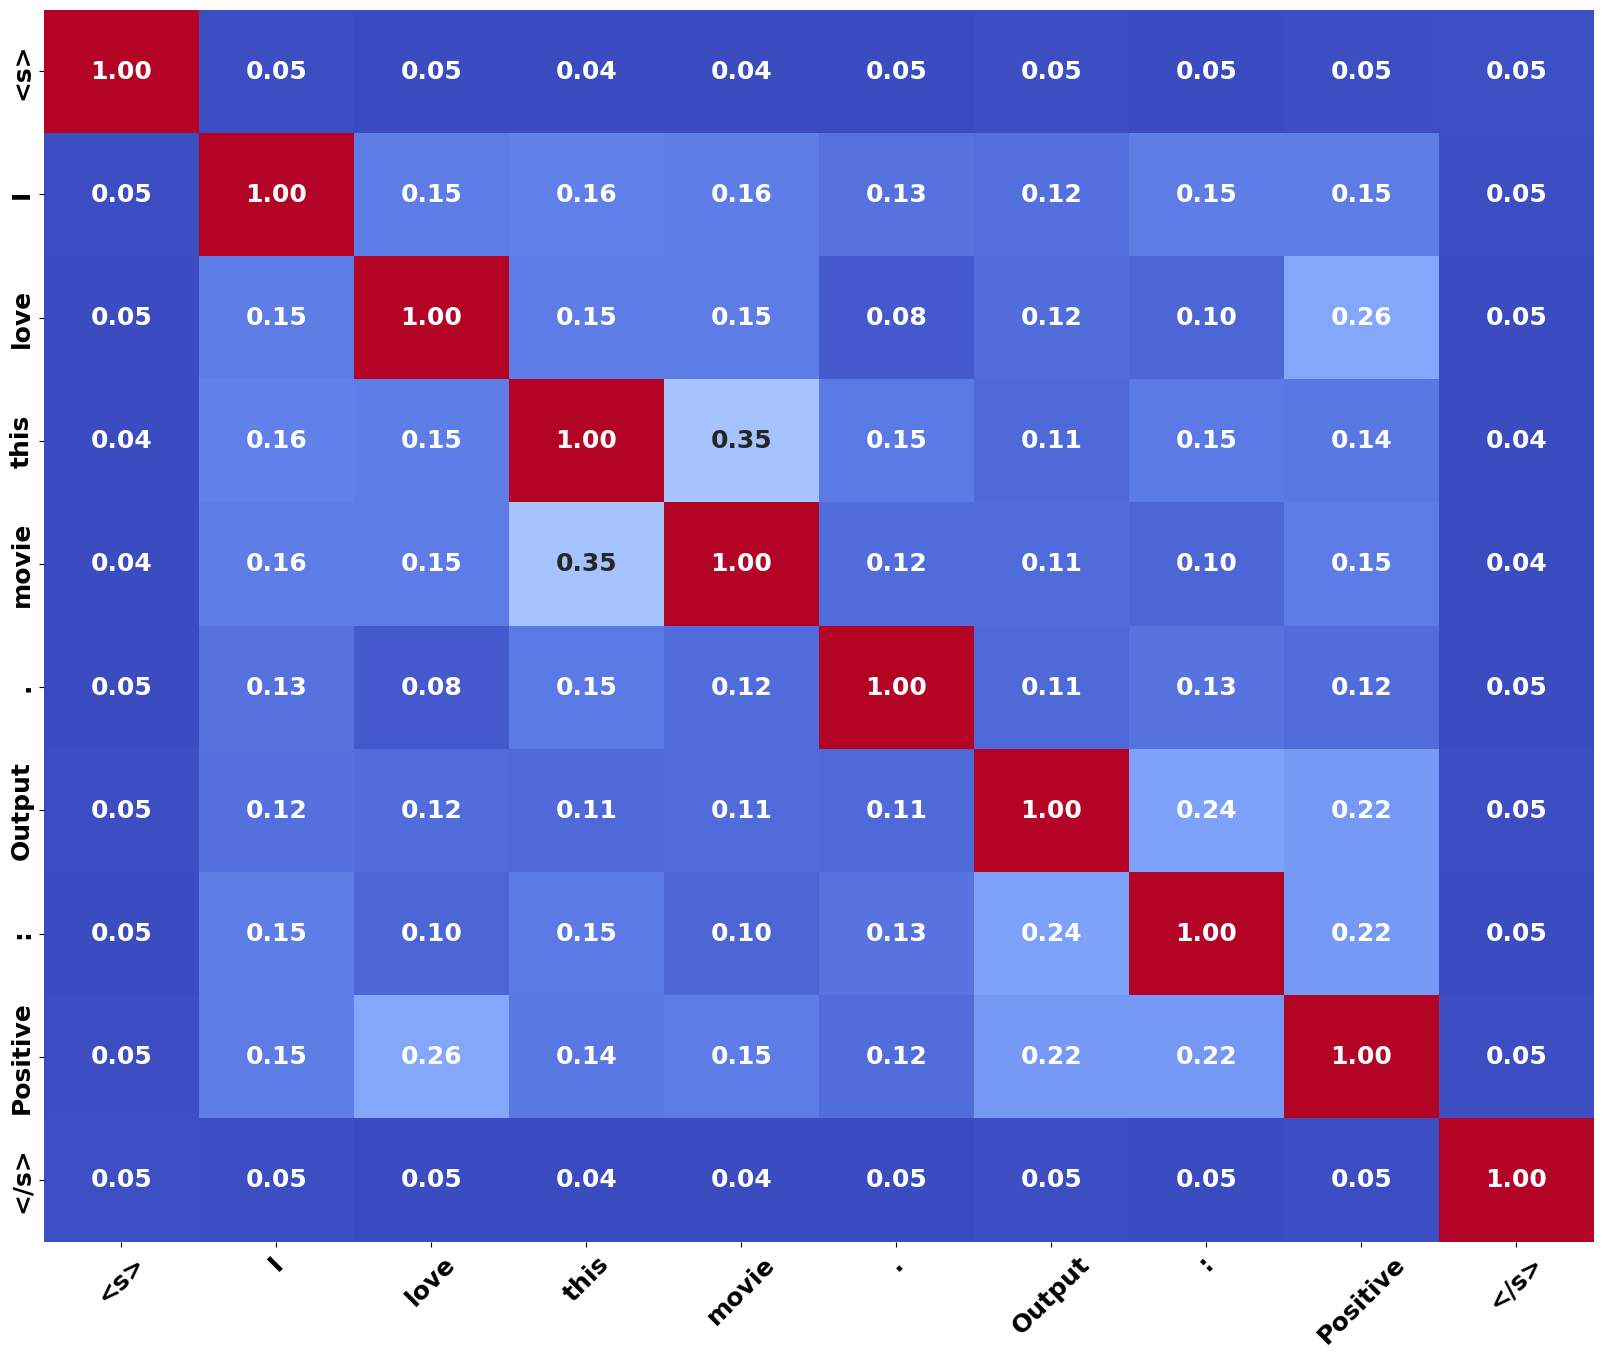

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams.update({"font.size": 18, "font.weight": "bold"})  # Default font size for other text elements
index=0
ranged=0
sample_batch = 0
plt.figure(figsize=(20, 16))
# Get token IDs you are plotting
token_ids = z['input_ids'][ranged:]

# Decode normally
decoded_tokens = [tokenizer.decode([i]) for i in token_ids]

# Replace first and last manually
decoded_tokens[0] = "<s>"
decoded_tokens[-1] = "</s>"

# Now use in heatmap
ax = sns.heatmap(
    mi_matrix[sample_batch, :, :], cmap="coolwarm", cbar=False,
    xticklabels=decoded_tokens,
    yticklabels=decoded_tokens,
    annot=True, fmt=".2f"
)


# Increase font size of tick labels (tokens)
plt.xticks(fontsize=18, fontweight="bold", rotation=45)  # Rotate if necessary
plt.yticks(fontsize=18, fontweight="bold")

# Save the figure
plt.savefig("sst_10.png", dpi=300, bbox_inches="tight")

# Show the figure
plt.show()

In [26]:
from torch.utils.data import DataLoader
from tqdm import tqdm
import torch
import pickle
from transformers import AutoTokenizer, DataCollatorWithPadding


tokenizer.padding_side = 'left'

# Define preprocessing function with truncation
def preprocessing_function(examples):
    # Adjust 'text' to your input column name
    return tokenizer(
        examples['input'],
        padding=False,  # Padding handled by collator
        truncation=True,
        max_length=512  # Set to your model's max length
    )

# Apply preprocessing with truncation
col_to_delete=['sentence', 'label', 'idx',  'input']
tokenized_train_data1 = train_data.select(range(3000)).map(
    preprocessing_function,
    batched=True,
    remove_columns=col_to_delete
)

# Set data collator with explicit max_length
data_collator = DataCollatorWithPadding(
    tokenizer=tokenizer,
    padding="max_length",
    max_length=512  # Match tokenizer's max_length
)

# Create DataLoader
dataloader = DataLoader(
    tokenized_train_data1,
    batch_size=16,
    collate_fn=data_collator,
    shuffle=False
)

# Proceed with model evaluation and feature extraction
model.eval()
model.cuda()

X_list = []
Z_layer_outputs = [[] for _ in range(model.config.num_hidden_layers)]
Y_list = []

for batch in tqdm(dataloader):
    input_ids = batch['input_ids'].cuda()
    attention_mask = batch['attention_mask'].cuda()
    labels = batch['labels']
    
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, output_hidden_states=True)
        hidden_states = outputs.hidden_states
        
        # Store embeddings (mean pooled)
        X_list.append(hidden_states[0].mean(dim=1).cpu())
        
        # Store layer outputs (mean pooled)
        for i, layer_out in enumerate(hidden_states[1:]):
            Z_layer_outputs[i].append(layer_out.mean(dim=1).cpu())
        
        Y_list.append(labels)

# Stack all tensors
X_tensor = torch.cat(X_list, dim=0)
Z_tensors = [torch.cat(layer, dim=0) for layer in Z_layer_outputs]
Z_tensor = torch.stack(Z_tensors, dim=0)
Y_tensor = torch.cat(Y_list, dim=0)

# Save dataset
dataset_dict = {'X': X_tensor, 'Z': Z_tensor, 'Y': Y_tensor}
with open('full_dataset_mlm.pkl', 'wb') as f:
    pickle.dump(dataset_dict, f)

ValueError: Column to remove ['sentence', 'idx'] not in the dataset. Current columns in the dataset: ['id', 'sentence_A', 'sentence_B', 'label', 'relatedness_score', 'entailment_AB', 'entailment_BA', 'sentence_A_original', 'sentence_B_original', 'sentence_A_dataset', 'sentence_B_dataset', 'labels', 'input']